In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import librosa 
from scipy.fftpack import fft
import pywt

In [1]:
# read .mat file
from scipy.io import loadmat
mat = loadmat('data/HPCpyra/HPCpyra_events_ratID3.mat')
# mat = loadmat('data/PFCshal/PFCshal_events_ratID3.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'HPCpyra_complex_swr_veh', 'HPCpyra_ripple_veh', 'HPCpyra_swr_veh'])

In [3]:
dataset = 'HPCpyra_ripple_veh'
y, sr = mat[dataset][0] , 600

spec = np.abs(librosa.stft(y,))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')



fig, ax = plt.subplots()

hop_length = 128

D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,

                         x_axis='time', ax=ax)
ax.set(title='Log-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

fig, ax = plt.subplots()

plt.plot(mat[dataset][0])

NameError: name 'np' is not defined

(30,)


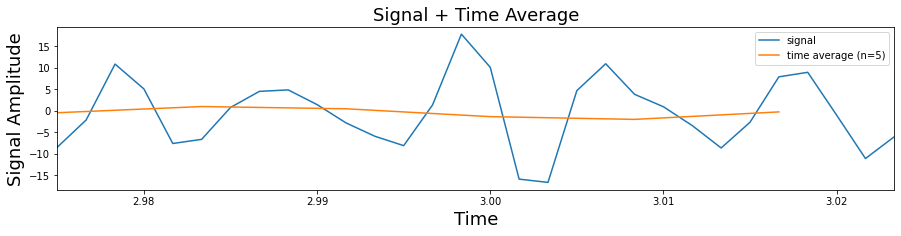

(15,) (15,)


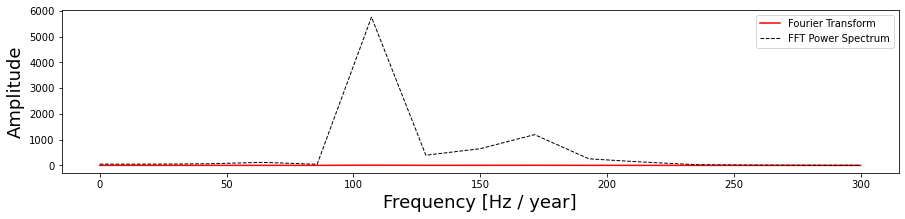

scale pseudo frequencies [30.         21.57534247 16.84491979 13.81578947 11.71003717 10.16129032
  8.97435897  8.03571429  7.27482679  6.64556962  6.11650485  5.66546763
  5.27638191  4.93730408  4.63917526  4.375       4.13929041  3.9276808
  3.7366548   3.56334842  3.40540541  3.26086957  3.12810328  3.00572519
  2.89256198  2.78761062  2.69000854  2.5990099   2.51396648  2.43431221
  2.35955056  2.28924419  2.22300635  2.16049383  2.10140093  2.04545455
  1.99240987  1.94204686  1.89416717  1.84859155  1.80515759  1.76371781
  1.72413793  1.6862955   1.65007858  1.61538462  1.58211954  1.55019685
  1.5195369   1.49006623  1.46171694  1.43442623  1.4081359   1.38279192
  1.35834411  1.33474576  1.31195335  1.28992629  1.26862666  1.24801902
  1.22807018  1.20874904  1.19002645  1.171875  ] (64,)


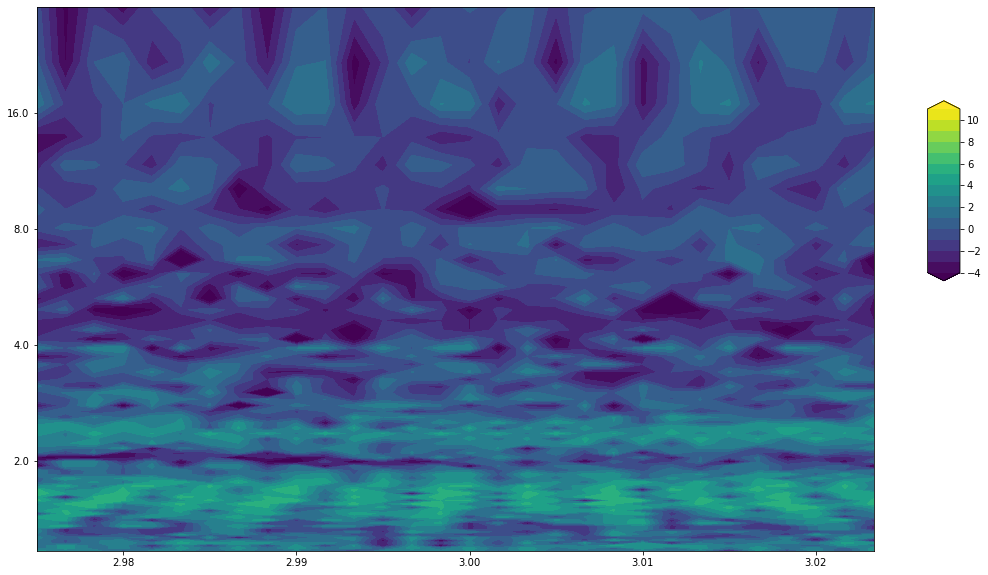

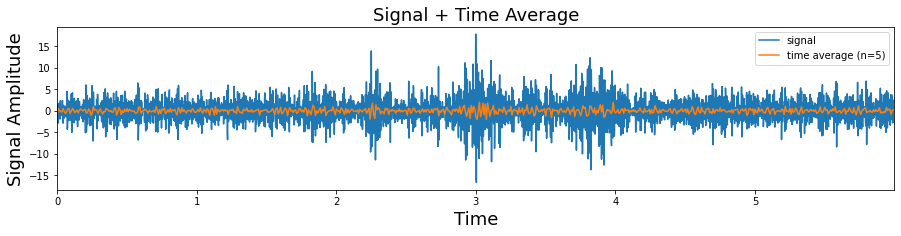

In [7]:

#taken from https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def plot_wavelet_freq(time, signal, scales, 
                 waveletname = 'mor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,16,32,64,128,256,512,1024,2048,]
    contourlevels = np.log2(levels)
    print('scale pseudo frequencies',frequencies,frequencies.shape)
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=cmap)
        
    yticks =  2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    plt.show()

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()


def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    print(f_values.shape, fft_values.shape)
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
    return f_values,fft_power
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave


df, sr= pd.DataFrame(mat[dataset][0]), 600
#swr
#does 0,7,8 counts as two ripples?
#complex
#5 is not aligned
#does 6 counts as two ripples?
N = df.shape[0]
t0=0
dt=1/sr
duration = 0.05
time = np.arange(int(N/2 - duration/2*sr), int(N/2 + duration/2*sr)) * dt + t0
signal = df.values.squeeze()[int(N/2-duration/2*sr):int(N/2+ duration/2*sr)]
print(time.shape)
scales = np.linspace(20,512, 64)#np.arange(1, 124)

plot_signal_plus_average(time, signal)
f_values,fft_power = plot_fft_plus_power(time, signal)
# plot_wavelet(time, signal, scales)
plot_wavelet_freq(time, signal, scales,waveletname='cmor1.5-1.0',cmap=None)

duration = 6
time = np.arange(int(N/2 - duration/2*sr), int(N/2 + duration/2*sr)) * dt + t0
signal = df.values.squeeze()[int(N/2-duration/2*sr):int(N/2+ duration/2*sr)]
plot_signal_plus_average(time, signal)



In [20]:
#check relation between scales and frequencies
pywt.scale2frequency('cmor1.5-1.0',np.linspace(20,512, 64))/dt


array([30.        , 21.57534247, 16.84491979, 13.81578947, 11.71003717,
       10.16129032,  8.97435897,  8.03571429,  7.27482679,  6.64556962,
        6.11650485,  5.66546763,  5.27638191,  4.93730408,  4.63917526,
        4.375     ,  4.13929041,  3.9276808 ,  3.7366548 ,  3.56334842,
        3.40540541,  3.26086957,  3.12810328,  3.00572519,  2.89256198,
        2.78761062,  2.69000854,  2.5990099 ,  2.51396648,  2.43431221,
        2.35955056,  2.28924419,  2.22300635,  2.16049383,  2.10140093,
        2.04545455,  1.99240987,  1.94204686,  1.89416717,  1.84859155,
        1.80515759,  1.76371781,  1.72413793,  1.6862955 ,  1.65007858,
        1.61538462,  1.58211954,  1.55019685,  1.5195369 ,  1.49006623,
        1.46171694,  1.43442623,  1.4081359 ,  1.38279192,  1.35834411,
        1.33474576,  1.31195335,  1.28992629,  1.26862666,  1.24801902,
        1.22807018,  1.20874904,  1.19002645,  1.171875  ])

(array([14., 12.,  8., 10., 13., 13.,  4.,  6.,  3.,  4.,  4.,  3.,  4.,
         1.,  1.]),
 array([ 0.        ,  3.33611343,  6.67222686, 10.00834028, 13.34445371,
        16.68056714, 20.01668057, 23.35279399, 26.68890742, 30.02502085,
        33.36113428, 36.69724771, 40.03336113, 43.36947456, 46.70558799,
        50.04170142]),
 <BarContainer object of 15 artists>)

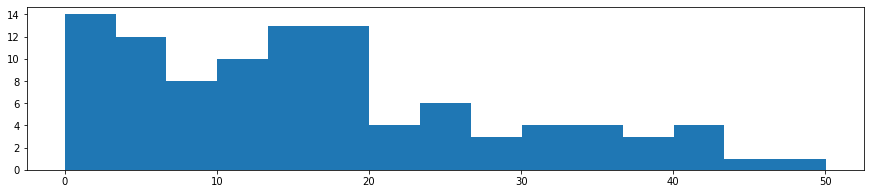

In [28]:
#pandas configure max display rows
pd.set_option('display.max_rows', None)

df =pd.DataFrame([f_values,fft_power]).T
df.columns = ['f_values','fft_power']
df.sort_values(by='fft_power', ascending=False, inplace=True)
df = df.head(100)
#plot histogram with first 100 fft power values
fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(df['f_values'], bins=15, density=False, label='FFT Power Spectrum')

Create csv with class distribution

In [16]:
import h5py
import json

data_df = pd.DataFrame(os.listdir('./proc_data/'), columns=['filename'])
data_df['rat_id'] = data_df.filename.apply(lambda x: int(x.split('_')[-1].split('.')[0].split('ratID')[1]))
data_df.rat_id.unique()
sizes = []
label_dict = {'complex':[], 'ripple':[], 'swr':[]}

for file in data_df.filename:

    #load h5 file
    f = h5py.File('./proc_data/'+file, 'r')
    label_arr = json.loads(f.attrs['data_types'])
    #get size of dataset
    sizes.append(f['x'].shape)
    y = pd.Series(f['y']).apply(lambda x: label_arr[x])
    # print(y.value_counts(),y[(~y.str.contains('complex')) & (y.str.contains('swr'))].shape[0])
    label_dict['complex'].append(y[y.str.contains('complex')].shape[0]) 
    label_dict['ripple'].append(y[y.str.contains('ripple')].shape[0])
    label_dict['swr'].append(y[~y.str.contains('complex') & y.str.contains('swr')].shape[0])
    f.close()
    # break
data_df['sizes'] = sizes
data_df['complex'] = label_dict['complex']
data_df['swr'] = label_dict['swr']
data_df['ripple'] = label_dict['ripple']
data_df


,filename,rat_id,sizes,complex,swr,ripple
0,dataset_HPCpyra_ratID210.hdf5,210,"(1005, 8, 60)",80,516,409
1,dataset_HPCpyra_ratID206.hdf5,206,"(1079, 8, 60)",354,167,558
2,dataset_HPCpyra_ratID3.hdf5,3,"(210, 8, 60)",51,29,130
3,dataset_PFCshal_ratID213.hdf5,213,"(300, 64, 2400)",107,54,139
4,dataset_HPCpyra_ratID203.hdf5,203,"(1016, 8, 60)",262,266,488
5,dataset_HPCpyra_ratID211.hdf5,211,"(925, 8, 60)",276,161,488
6,dataset_PFCshal_ratID203.hdf5,203,"(1016, 64, 2400)",262,266,488
7,dataset_PFCshal_ratID206.hdf5,206,"(1079, 64, 2400)",354,167,558
8,dataset_PFCshal_ratID4.hdf5,4,"(546, 64, 2400)",291,25,230
9,dataset_PFCshal_ratID210.hdf5,210,"(1005, 64, 2400)",80,516,409


In [17]:
data_df.to_csv('class_distribution.csv', index=False)